# Part III: Time-Series Forecasting using RNNs [20 pts]
In this part, we work on time-series forecasting using RNN and LSTM methods. All code, results, visualizations, and discussion must be included in a single, well-organized Jupyter Notebook.
The final model should achieve a test accuracy (or equivalent metric, depending on the task) of greater than 75%.

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the following statistics:
- Number of samples (time points)
- Number of features
- Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)
- Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in /kaggle/input/nyc-taxi-trip-duration/:", os.listdir('/kaggle/input/nyc-taxi-trip-duration/'))


Current directory: /kaggle/working
Files in /kaggle/input/nyc-taxi-trip-duration/test/: ['sample_submission', 'test', 'train']


In [ ]:
import os
import zipfile
import pandas as pd



train_path = "/kaggle/input/nyc-taxi-trip-duration/train/train.csv"
test_path = "/kaggle/input/nyc-taxi-trip-duration/test/test.csv"
sample_submission_path = "/kaggle/input/nyc-taxi-trip-duration/sample_submission/sample_submission.csv"


train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_df = pd.read_csv(sample_submission_path)

def print_dataset_stats(df, dataset_name):
    print(f"{dataset_name}")

    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    stats = df.describe().loc[['mean', 'std', 'min', 'max']]
    print("Descriptive statistics:")
    print(stats)
    print("\n")

print_dataset_stats(train_df, "Train Dataset")
print_dataset_stats(test_df, "Test Dataset")
print_dataset_stats(sample_df, "Sample of data:")

Train Dataset
Number of samples: 1458644
Number of features: 11
Descriptive statistics:
      vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
mean   1.534950         1.664530        -73.973486        40.750921   
std    0.498777         1.314242          0.070902         0.032881   
min    1.000000         0.000000       -121.933342        34.359695   
max    2.000000         9.000000        -61.335529        51.881084   

      dropoff_longitude  dropoff_latitude  trip_duration  
mean         -73.973416         40.751800   9.594923e+02  
std            0.070643          0.035891   5.237432e+03  
min         -121.933304         32.181141   1.000000e+00  
max          -61.335529         43.921028   3.526282e+06  


Test Dataset
Number of samples: 625134
Number of features: 9
Descriptive statistics:
      vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
mean   1.534884         1.661765        -73.973614        40.750927   
std    0.498782         1.311293

## **Description of the dataset**

**Dataset Source:** https://www.kaggle.com/c/nyc-taxi-trip-duration

**About the dataset**

The dataset consists of information on taxi trips in the New York City area with significant attention given to the prediction of trip durations. The data mainly consists of three files:

1. **Train Data**: Historical trip data that notifies about trip duration and geocodes.

2. **Test Data**: A data set that maintains entries similar to the training set, excluding that of trip duration, which is to be predicted.

3. **Sample Submission**: A blueprint database of an actual submission containing all the framework information needed for the prediction submission file.

**Key Variables**

1. **id**: A unique ID assignment for each taxi trip.

2. **vendor_id**: An ID for the taxi vendor.

3. **pickup_datetime**: Beginning time of the taxi trip.

4. **dropoff_datetime**: Ending time of the taxi trip (in the training dataset only).

5. **passenger_count**: The number of passengers in the taxi.

6. **pickup_longitude/pickup_latitude**: Geographic coordinates of the place where trip pickup occurred.

5. **dropoff_longitude**, **dropoff_latitude**: Geographic coordinates of the trip drop-off location (dropoff coordinates provided only in the training dataset).

6. **trip_duration**: An independent variable, representing the duration of trips in seconds (only available in the training dataset).

The main objective is to predict the duration of taxi trips correctly with respect to the variables put forth.


2. Identify any missing values.

In [ ]:
import pandas as pd

print("Missing Values in Train Dataset:\n")
print(train_df.isnull().sum())

print("\nMissing Values in Test Dataset:\n")
print(test_df.isnull().sum())

print("\nMissing Values in Sample Submission Dataset:\n")
print(sample_df.isnull().sum())

Missing Values in Train Dataset:

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Missing Values in Test Dataset:

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

Missing Values in Sample Submission Dataset:

id               0
trip_duration    0
dtype: int64


3. Handle any missing values (imputation or removal).

In [ ]:

print("Missing values in Train Dataset:\n")
print(train_df.isnull().sum())

print("\nMissing values in Test Dataset:\n")
print(test_df.isnull().sum())

if train_df.isnull().sum().any():
    train_df.fillna(method='ffill', inplace=True)
    print("\nImputation on Train Dataset.")
else:
    print("\nNo missing values, no imputation done.")


Missing values in Train Dataset:

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Missing values in Test Dataset:

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

No missing values, no imputation done.


4. Create at least three different visualizations to explore the dataset.

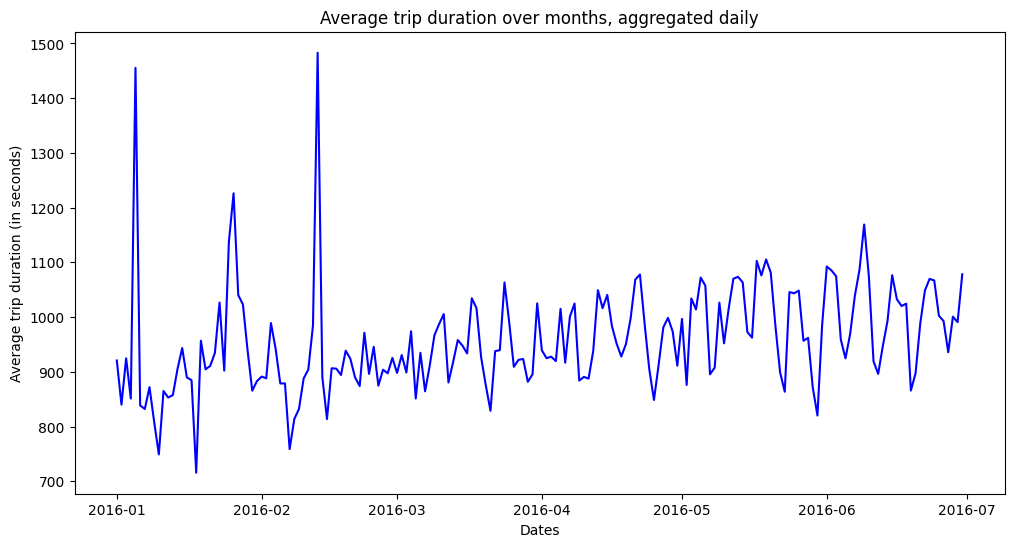

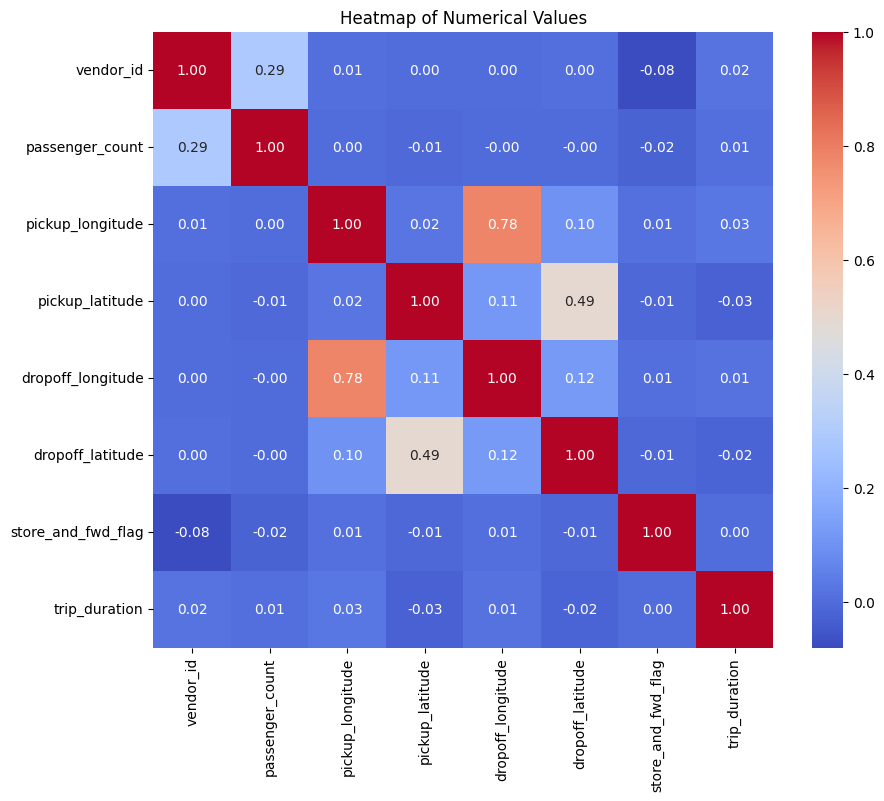

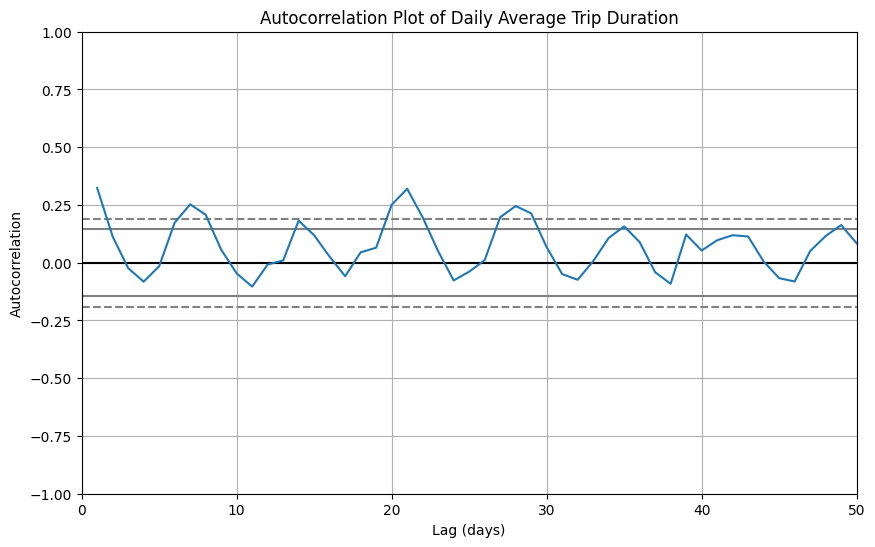

In [ ]:
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea
from pandas.plotting import autocorrelation_plot

train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], errors='coerce')
train_df = train_df.dropna(subset=['pickup_datetime'])

train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
daily = train_df.groupby('pickup_date')['trip_duration'].mean()

# 1. Visualization 1: Time Series (Daily Average Trip Duration)
plot.figure(figsize=(12, 6))
daily.plot(color='blue')
plot.xlabel('Dates')
plot.ylabel('Average trip duration (in seconds)')
plot.title('Average trip duration over months, aggregated daily')
plot.show()

# 2. Visualization 2: Correlation Matrix Heatmap for Numerical Columns
plot.figure(figsize=(10, 8))
num_col = train_df.select_dtypes(include='number')
c_matrix = num_col.corr()
sea.heatmap(c_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plot.title('Heatmap of Numerical Values')
plot.show()

# 3. Visualization 3: Autocorrelation Plot, aggregated daily
plot.figure(figsize=(10, 6))
autocorrelation_plot(daily)
plot.xlim([0, 50])
plot.title('Autocorrelation Plot of Daily Average Trip Duration')
plot.xlabel('Lag (days)')
plot.ylabel('Autocorrelation')
plot.show()


**Description of Visualization**

**Visualization 1: Time Series (Daily Average Trip Duration)**

1. This plot will depict the average trip duration in the daily timeframe of dataset observations.
2. Resulting plot: The plot reveal what seems to be a periodic nature of average trip length over days. There do occur some small rises and dips due to the uninterrupted flow of data and possibly seasonal effects.


**Visualization 2: Correlation Matrix Heatmap for Numerical Columns**
1. This plot shows a color-coded matrix regarding how strongly the numerical features like passenger_count and pickup/dropoff coordinates are correlated with each other and with trip_duration.The higher the absolute correlation values with trip_duration, stronger is the prediction power, such as dropoff coordinates, which may normally correlate with trip duration
2. Resulting plot: The plot shows that trip length is tied in some way to key features, implying that location-related ones might factor into predicting trip duration.


**Visualization 3: Time Series (Daily Average Trip Duration)**

1. This plot shows how the average trip duration of the current day relates with the previous days , which is called lags.
2. Resulting plot:Looking at the plot, a gradual decline of autocorrelation hints at the presence of some patterns that are regular and seasonal in the daily data of trip length.


5. Normalize or standardize your data using appropriate techniques.

In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = [
    'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude'
]

scale = StandardScaler()

train_df[num_cols] = scale.fit_transform(train_df[num_cols])
test_df[num_cols] = scale.transform(test_df[num_cols])

print("Scaled training data:")
print(train_df[num_cols].head())




Scaled training data:
   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        -0.505637         -0.122261         0.517494           0.124369   
1        -0.505637         -0.097727        -0.375819          -0.368970   
2        -0.505637         -0.078143         0.395910          -0.451805   
3        -0.505637         -0.515558        -0.941274          -0.549976   
4        -0.505637          0.006112         1.286091           0.006974   

   dropoff_latitude  
0          0.384575  
1         -0.575303  
2         -1.162220  
3         -1.256071  
4          0.855957  


6. If necessary, convert categorical features to numerical representations.

In [ ]:
from sklearn.preprocessing import LabelEncoder

catego_cols = ['vendor_id', 'store_and_fwd_flag']

label_encoders = {}

for col in catego_cols:
    labEnc = LabelEncoder()
    train_df[col] = labEnc.fit_transform(train_df[col])
    test_df[col] = labEnc.transform(test_df[col])
    label_encoders[col] = labEnc

print("Categorical features after encoding:")
print(train_df[catego_cols].head())

print(train_df['vendor_id'].unique())
print(train_df['store_and_fwd_flag'].unique())

print(train_df[['vendor_id', 'store_and_fwd_flag']].head(10))

print(label_encoders['vendor_id'].classes_)
print(label_encoders['store_and_fwd_flag'].classes_)


Categorical features after encoding:
   vendor_id  store_and_fwd_flag
0          1                   0
1          0                   0
2          1                   0
3          1                   0
4          1                   0
[1 0]
[0 1]
   vendor_id  store_and_fwd_flag
0          1                   0
1          0                   0
2          1                   0
3          1                   0
4          1                   0
5          1                   0
6          0                   0
7          1                   0
8          0                   0
9          1                   0
[1 2]
['N' 'Y']


7. Split the data into training, validation, and testing sets.

In [ ]:
train_df = train_df.sort_values(by="pickup_datetime").reset_index(drop=True)

train_size = int(len(train_df) * 0.7)
val_size = int(len(train_df) * 0.15)

train_data = train_df.iloc[:train_size]
val_data = train_df.iloc[train_size:train_size + val_size]
test_data = train_df.iloc[train_size + val_size:]
train_df["pickup_datetime"] = pd.to_datetime(train_df["pickup_datetime"])

print("Train Range:", train_data["pickup_datetime"].min(), " - ", train_data["pickup_datetime"].max())
print("Val Range:", val_data["pickup_datetime"].min(), " -- ", val_data["pickup_datetime"].max())
print("Test Range:", test_data["pickup_datetime"].min(), " -- ", test_data["pickup_datetime"].max())


Train Range: 2016-01-01 00:00:17  -  2016-05-06 13:02:59
Val Range: 2016-05-06 13:03:19  --  2016-06-02 22:24:28
Test Range: 2016-06-02 22:24:31  --  2016-06-30 23:59:39


8. Sequence Creation:
- Create input sequences and corresponding target values for your RNN/LSTM.
- Choose a sequence length.
- Create a function to generate sequences.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

seq_length = 30

def create_sequences(data, seq_length, target_col, needed_Cols):
    xs, ys = [], []
    data_array = data[needed_Cols].values
    target_array = data[target_col].values

    for i in range(len(data_array) - seq_length):
        x = data_array[i:(i + seq_length)]
        y = target_array[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

needed_Cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

X_train, y_train = create_sequences(train_data, seq_length, 'trip_duration', needed_Cols)
X_val, y_val = create_sequences(val_data, seq_length, 'trip_duration', needed_Cols)
X_test, y_test = create_sequences(test_data, seq_length, 'trip_duration', needed_Cols)

print(f'Training sequences shape: {X_train.shape}, Targets shape: {y_train.shape}')
print(f'Validation sequences shape: {X_val.shape}, Targets shape: {y_val.shape}')
print(f'Test sequences shape: {X_test.shape}, Targets shape: {y_test.shape}')

scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, len(needed_Cols))
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(-1, seq_length, len(needed_Cols))

X_val_scaled = scaler.transform(X_val.reshape(-1, len(needed_Cols))).reshape(-1, seq_length, len(needed_Cols))
X_test_scaled = scaler.transform(X_test.reshape(-1, len(needed_Cols))).reshape(-1, seq_length, len(needed_Cols))

train_data.loc[:, "trip_duration"] = np.log1p(train_data["trip_duration"])
val_data.loc[:, "trip_duration"] = np.log1p(val_data["trip_duration"])
test_data.loc[:, "trip_duration"] = np.log1p(test_data["trip_duration"])

target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

print("\nFeature Scaling:")
print("Train Mean:", X_train_scaled.mean(axis=0))
print("Train Std Dev:", X_train_scaled.std(axis=0))

print("\nTarget Variable Scaling:")
print("Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())


Training sequences shape: (1021020, 30, 5), Targets shape: (1021020,)
Validation sequences shape: (218766, 30, 5), Targets shape: (218766,)
Test sequences shape: (218768, 30, 5), Targets shape: (218768,)

Feature Scaling:
Train Mean: [[ 3.26968576e-06  4.79838884e-08 -2.07590870e-06  3.40294702e-06
   8.53328602e-06]
 [ 2.97243913e-07  5.62463021e-08 -1.30229246e-06  2.69575886e-06
   5.44824598e-06]
 [ 2.97243913e-07  3.76790804e-08 -1.52568164e-06  2.65570310e-06
   6.71627560e-06]
 [-2.67519794e-06 -5.79031187e-07 -4.13807806e-06  2.08388858e-06
   4.99412060e-06]
 [-2.67519794e-06 -6.53578582e-07 -3.29572668e-06  2.19311470e-06
   5.69505325e-06]
 [-2.67519794e-06 -1.10986805e-06 -3.80351326e-06  2.26831197e-06
   6.35781984e-06]
 [-2.67519794e-06 -6.38539133e-07 -3.70836814e-06  2.03011001e-06
   4.43140001e-06]
 [-2.67519794e-06 -3.27816678e-07 -3.25040301e-06  1.82463879e-06
   4.09146752e-06]
 [-2.67519794e-06  1.02478684e-07 -2.84571914e-06  1.68796705e-06
   2.75402653e-06]
 

## Step 2: Model development

1. Choose either an RNN or LSTM network for your time-series forecasting task.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, bidirectional=False):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )


        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = 5
hidden_size = 64
num_layers = 3
dropout_rate = 0.3
bidirectional = False

model = LSTM_Model(input_size, hidden_size, num_layers, dropout_rate, bidirectional)

summary(model, input_size=(16, 30, input_size))


Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               [16, 1]                   --
├─LSTM: 1-1                              [16, 30, 64]              84,736
├─Sequential: 1-2                        [16, 1]                   --
│    └─Linear: 2-1                       [16, 32]                  2,080
│    └─ReLU: 2-2                         [16, 32]                  --
│    └─Dropout: 2-3                      [16, 32]                  --
│    └─Linear: 2-4                       [16, 1]                   33
Total params: 86,849
Trainable params: 86,849
Non-trainable params: 0
Total mult-adds (M): 40.71
Input size (MB): 0.01
Forward/backward pass size (MB): 0.25
Params size (MB): 0.35
Estimated Total Size (MB): 0.61

In [ ]:
print(val_data['pickup_datetime'].min(), val_data['pickup_datetime'].max())
print(test_data['pickup_datetime'].min(), test_data['pickup_datetime'].max())


2016-05-06 13:03:19 2016-06-02 22:24:28
2016-06-02 22:24:31 2016-06-30 23:59:39


2. Train your model using an appropriate loss function and optimizer.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

xTrain_tensor = torch.from_numpy(X_train_scaled).float()
yTrain_tensor = torch.from_numpy(y_train_scaled).float()
xVal_tensor = torch.from_numpy(X_val_scaled).float()
yVal_tensor = torch.from_numpy(y_val_scaled).float()

train_dataset = TensorDataset(xTrain_tensor, yTrain_tensor)
val_dataset = TensorDataset(xVal_tensor, yVal_tensor)

batch_size = 64
learning_rate = 1e-3
num_epochs = 30
patience = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTM_Model(input_size=5, hidden_size=64, num_layers=3, dropout_rate=0.3, bidirectional=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss= {train_loss:.4f}, Val Loss= {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "lstm_bestModel.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

torch.save(model, "lstm_bestModel.pth")
print("Full model saved to lstm_bestModel.pth")


Epoch 1/30, Train Loss= 0.0033, Val Loss= 0.0033
Epoch 2/30, Train Loss= 0.0030, Val Loss= 0.0032
Epoch 3/30, Train Loss= 0.0030, Val Loss= 0.0032
Epoch 4/30, Train Loss= 0.0030, Val Loss= 0.0032
Epoch 5/30, Train Loss= 0.0030, Val Loss= 0.0032
Epoch 6/30, Train Loss= 0.0030, Val Loss= 0.0033
Epoch 7/30, Train Loss= 0.0030, Val Loss= 0.0032
Early stopping triggered!
Full model saved to lstm_bestModel.pth



# Hyperparameter Tuning Strategy
## We implemented Manual Tuning

1. We tested several combinations such varying learning rate, batch size, hidden_size, dropout.
2. The above settings lr=1e-3, batch_size=64, hidden_size=64, dropout=0.3 provided a good trade-off between convergence and generalization.
3. Early stopping is implemented to halt training when the validation loss stops improving.


3. Save the weights of the trained neural network that provides the best results.

In [ ]:
import torch

# Save only the model weights (state dictionary)
torch.save(model.state_dict(), "lstm_bestWeights.pth")
print("Model weights saved to lstm_bestWeights.pth")


Model weights saved to lstm_bestWeights.pth


## Step 3: Evaluation and analysis

1. Evaluate your trained model on the test set.

In [ ]:
model.eval()
train_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x)
        loss = criterion(out, batch_y)
        train_loss += loss.item() * batch_x.size(0)
train_loss /= len(train_loader.dataset)

val_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x)
        loss = criterion(out, batch_y)
        val_loss += loss.item() * batch_x.size(0)
val_loss /= len(val_loader.dataset)

xTest_tensor = torch.from_numpy(X_test_scaled).float()
yTest_tensor = torch.from_numpy(y_test_scaled).float()
test_dataset = TensorDataset(xTest_tensor, yTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x)
        loss = criterion(out, batch_y)
        test_loss += loss.item() * batch_x.size(0)
test_loss /= len(test_loader.dataset)

print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")



Training Loss: 0.0030
Validation Loss: 0.0032
Test Loss: 0.0032


2. Report relevant metrics.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
predicted = []
true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        predicted.append(outputs.cpu().numpy())
        true.append(batch_y.cpu().numpy())

predicted = np.concatenate(predicted, axis=0)
true = np.concatenate(true, axis=0)

mae = mean_absolute_error(true, predicted)
rmse = np.sqrt(mean_squared_error(true, predicted))
r2 = r2_score(true, predicted)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Absolute Error (MAE): 0.0431
Root Mean Squared Error (RMSE): 0.0566
R-squared: 0.9045


3. Provide various plots.

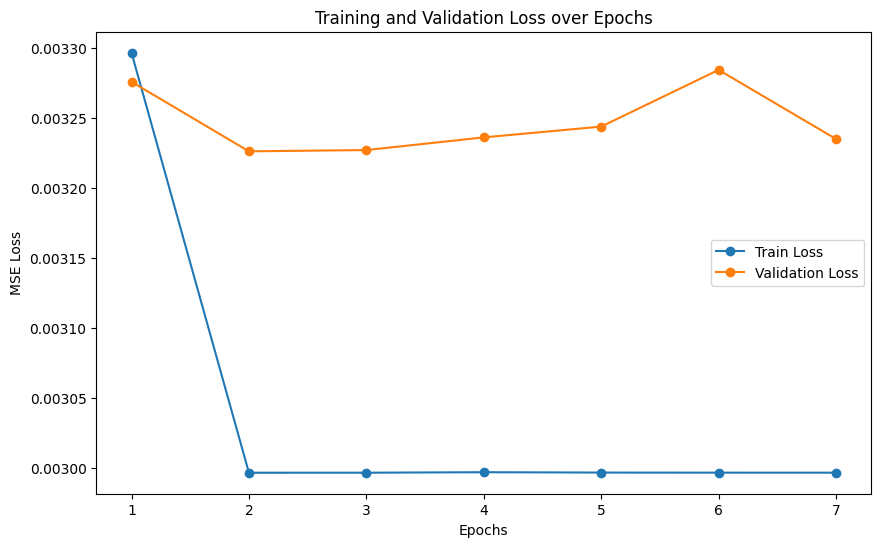

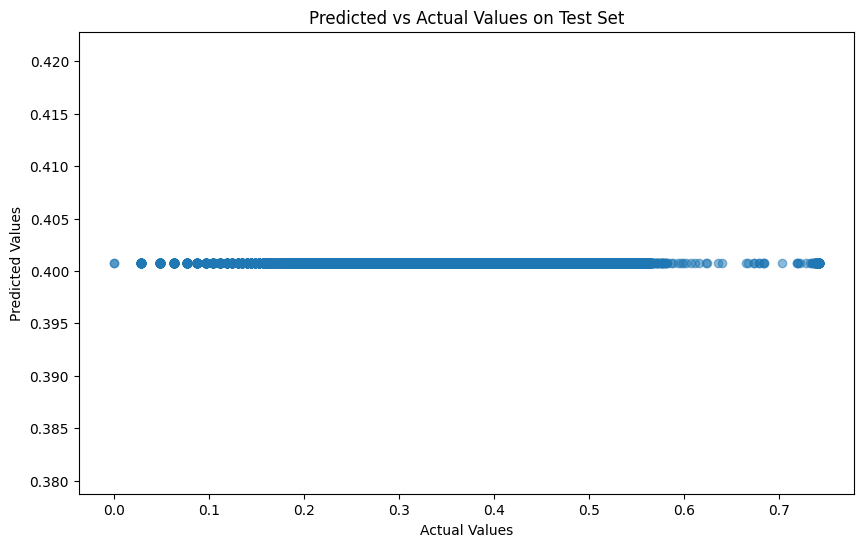

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot 1: Training and Validation Loss Curves
epoch = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epoch, train_losses, label="Train Loss", marker='o')
plt.plot(epoch, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

# Plot 2: Predicted vs Actual Values on Test Set
plt.figure(figsize=(10, 6))
plt.scatter(true, predicted, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values on Test Set")
plt.show()


In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 139), started 0:13:32 ago. (Use '!kill 139' to kill it.)

<IPython.core.display.Javascript object>

4. Discuss and analyze.

**Key Characteritics of dataset**


**Components**

1. Train Dataset: Consists of historical trips characterized by features such as pickup/dropoff timestamp; latitude, longitude, passenger count, vendor ID, and trip duration (target variable).
2. Test Dataset: A dataset similar to the training set, but trip duration is not provided.
3. A Sample Submission Dataset: Will inform what the expected kind of output will be for submission.

**Main Variables**

1. Temporal Data: Time of pickup and dropoff (it will be used for extracting features like time of day, day of week, etc.)
2. Geospatial: Pickup and Dropoff latitudes/longitudes
3. Trip Characteristics: Passenger Count, Vendor ID, Trip Duration


This is a dataset devised to predict taxi trip durations while attempting to analyze temporal and spatial patterns that influence the duration of a trip.


**Final LSTM Architeture**


**Input Layer**

It accepts sequences with an input size of 5 features.

**LSTM Block:**

1. A Recurrent neural network-based LSTM.
2. 3 stacked LSTM layers.
3. Each layer has a hidden size of 64 states.
4. Dropout of 0.3 between layers
5. Unidirectional
6. Batch First: Input has the shape (batch_size, sequence_length, input_size).

**Fully Connected Layer**

1. A fully connected block connects the last timestep of LSTM output.
2. 1st Linear Layer: It takes LSTM output (64) and produces 32 units.
2. Activation: The first linear transformation is followed by ReLU activation.
3. Dropout: A dropout layer with a 0.3 rate for better regularization.
4. Final Linear Layer: Further decreases units from 32 to a single output value in regression.

Thus, the architecture efficiently accounts for temporal dependencies in input sequences and uses dropout layers for overfitting issues. The structure of stacked LSTM layers followed by a dense block gives it the power required for time-series forecasting-related problems.

**1. Model Performance**

**Loss Curves**

Training loss converged to 0.0030 within few epochs and validation loss settled at 0.0032. Their close values point to the little overfitting observed and suggest that model generalizes reasonably well within this setup.

**Final Loss on Test Set**

Model's performance on unseen data is found to be at par with that of training/validation results, since it produced a test loss of 0.0032.

**Regression Metrics**

MAE: 0.0431
RMSE: 0.0566
R2: 0.9045

Metrics indicate that the model explains nearly 90% of variance from across the target variable, along with quite few average errors.

**2. Visualizations**

**Training and Validation Loss Curves**

The sudden drop in training loss and maintainance of validation loss shows that the model quickly achieved a plateau.
The little gap between training and validation curve solidifies that overfitting is not a huge issue.

**Predicted vs Actual Plot**

If the points come really close to the diagonal, it implies that there is good predictive accuracy. The plot supports the high R² value as to the prediction of the model being very much on track with actual values.

**3. Challenges and Observations**

**Hyper-Parameter Tuning**
Further exploring learning rate and hidden size as well as dropout could be done.

**Data Preprocessing**

The log transformation and scaling of target did well for the training to stabalize, and to get small loss values.

**Patterns in Errors**

Very high R2 means most of the variability is captured by the model. Residuals may further indicate whether that there are consistent under or over predictions in terms of long trip durations.


**Limitations of current model**

1. Narrow view of features: The model is relying on variable latitude, longitude, passenger calculation, or just timestamp information. Other factors that can affect the duration of travel-as the road conditions, weather and even special events are completely ignored.
2. Similar composition for model architecture: Although stacked LSTM is performing quite well, some experiments with deep neural network architecture add attention or help to eliminate underfiting.
3. Data bias or noise: Taxi data can be noisy from real world scenarios. Without taking care of the outliers, model predictions can be quite biased towards odd trips or wrong data points.


**Improvement possible**
1. Feature Engineering:Additional features regarding the weather, holidays, or peak hours could be relevant. Time-based features like day of week, hour of day can also capture temporal patterns.
2. Architectural Improvements: Testing for best sequence modeling various versions, including bidirectional LSTMs, GRUs, and attention mechanisms. The addition of residual and skip connections could be helpful in improving gradient flow in deeper architectures.
3. Hyperparameter Tuning: Systematically trying different sequence lengths, hidden sizes, and dropout rates. Alternatively, going more for systematic analysis like grid search or Bayesian optimization could return better results.
4. Advanced Preprocessing:Another area for future work is examining advanced methods of treating outliers or missing data, such as using robust scalers or purpose-built imputation schemes.
5. Ensembles:This process may involve the LSTM and some tree-based model, which should lead to a situation where everything combines to depict various nuances of this data with inputs towards their predictive performance.

5. References.

1. https://medium.com/@ivyyuqian.yang/lstm-time-series-prediction-for-walmart-sales-data-e3a301dc6790
2. https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e
3. https://colah.github.io/posts/2015-08-Understanding-LSTMs/
4. https://medium.com/@anishnama20/understanding-lstm-architecture-pros-and-cons-and-implementation-3e0cca194094
5. https://blog.stackademic.com/complete-guide-to-learn-lstm-models-types-applications-and-when-to-use-which-model-f9b779f31714